# Test Models

In [1]:
!unzip files.zip

Archive:  files.zip
  inflating: data/i000000.jpg        
  inflating: data/i000001.jpg        
  inflating: data/i000002.jpg        
  inflating: data/i000003.jpg        
  inflating: data/i000004.jpg        
  inflating: data/i000005.jpg        
  inflating: data/i000006.jpg        
  inflating: data/i000007.jpg        
  inflating: data/i000008.jpg        
  inflating: data/i000009.jpg        
 extracting: dataset/__init__.py     
  inflating: dataset/InferenceDataset.py  
  inflating: dataset/ReferenceDataset.py  
  inflating: files/desktop.ini       
  inflating: files/Instructions Final Project.pdf  
  inflating: files/Pitch_template.pptx  
  inflating: files/report_group_XX.tex  
   creating: model_results/FSRCNN/
  inflating: model_results/FSRCNN/four_matrices.png  
  inflating: model_results/FSRCNN/IFC.jpg  
  inflating: model_results/FSRCNN/mean_four_matrices.txt  
  inflating: model_results/FSRCNN/MSE.jpg  
  inflating: model_results/FSRCNN/PSNR.jpg  
  inflating: model_resu

In [2]:
# base imports
import random

# Torch
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler

# visualization
from utils.vis import zoom_and_display_data
from utils.vis import visualize_data, visualize_images, zoom_and_display_results
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Dataset
from dataset.ReferenceDataset import ReferenceDataset
from dataset.InferenceDataset import InferenceDataset

# Networks
from nets.srcnn import SRCNN
from nets.fsrcnn import FSRCNN
from nets.PaperSR import PaperSR
from nets.ResFSRCNN import ResFSRCNN
from nets.SRGAN import Generator

# Eval Metrics
from utils.eval.mse import mse_loss
from utils.eval.psnr import psnr
from utils.eval.ssim import ssim
from utils.eval.ifc import ifc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

Tesla T4


In [3]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.0001
SCALE_FACTOR = 4  # Factor by which images are downscaled

torch.manual_seed(0)

## Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Transform
transform = transforms.Compose([transforms.ToTensor(),])

# Create datasets
#pathToData = "./data"
pathToData = "/content/drive/MyDrive/filtered"
dataset = ReferenceDataset(pathToData, transform=transform, scale_factor=SCALE_FACTOR)

# Create dataloaders
testAndValProportion = 0.1
partition1 = int(len(dataset) * testAndValProportion)
partition2 = int(len(dataset) * 2 * testAndValProportion)

indicies = list(range(len(dataset)))
random.shuffle(indicies)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(indicies[partition2:]))
val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(indicies[partition1:partition2]))
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(indicies[:partition1]))

print(f"Number of batches: {len(train_loader)}")

Number of batches: 276


## Visualize Test Data

In [6]:
randomize_idx = True  # Set to False to disable randomization

# Randomly select an image from the training set
test_set_length = len(dataset)
random_index = random.randint(0, test_set_length - 1) if randomize_idx else 0
print(f"Random index: {random_index}")

low_res, high_res = dataset[random_index]
print(low_res.shape, high_res.shape)

Random index: 10954
torch.Size([3, 200, 200]) torch.Size([3, 800, 800])


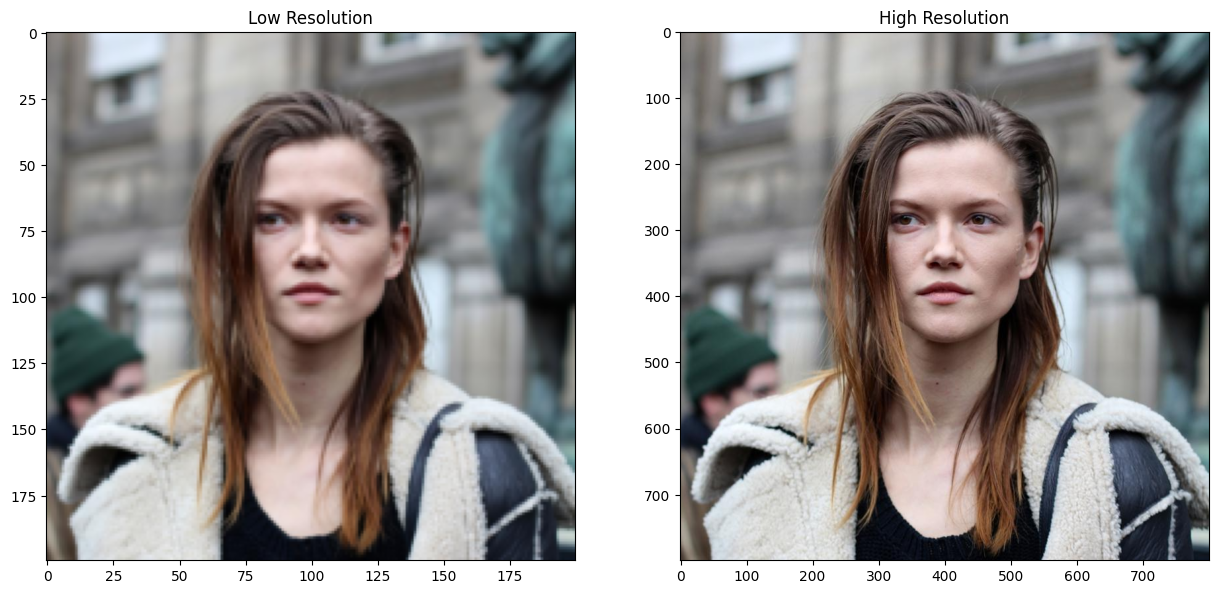

In [7]:
visualize_data(low_res, high_res)

### Zooming in on the data

In [8]:
# Calculate scale factors
scale_factor_x = high_res.shape[-1] / low_res.shape[-1]
scale_factor_y = high_res.shape[-2] / low_res.shape[-2]

assert scale_factor_x == scale_factor_y, "Scale factors are not equal"

print(f'Scale Factor: {SCALE_FACTOR}')

Scale Factor: 4


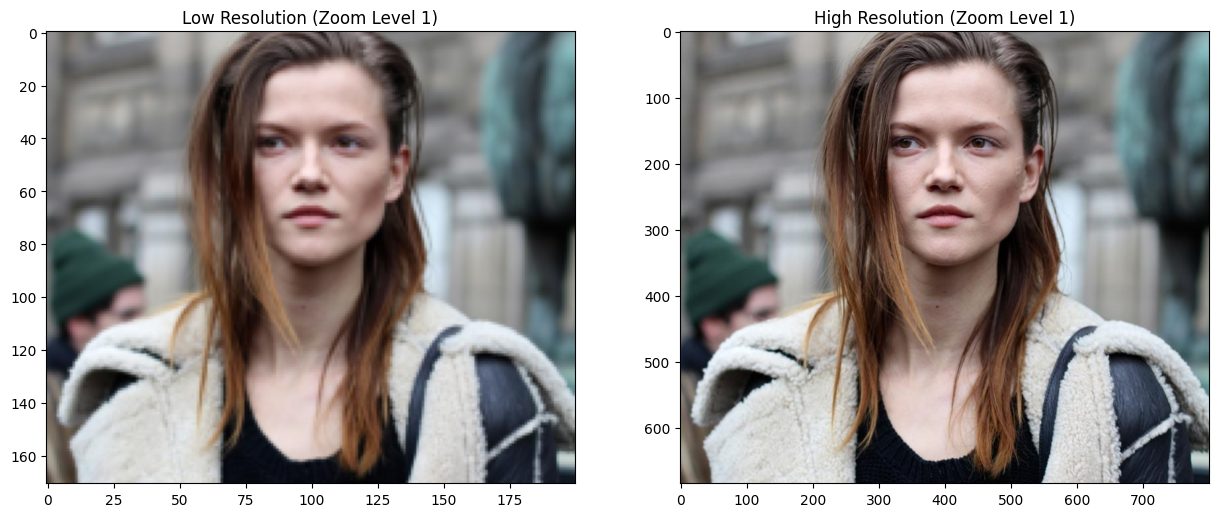

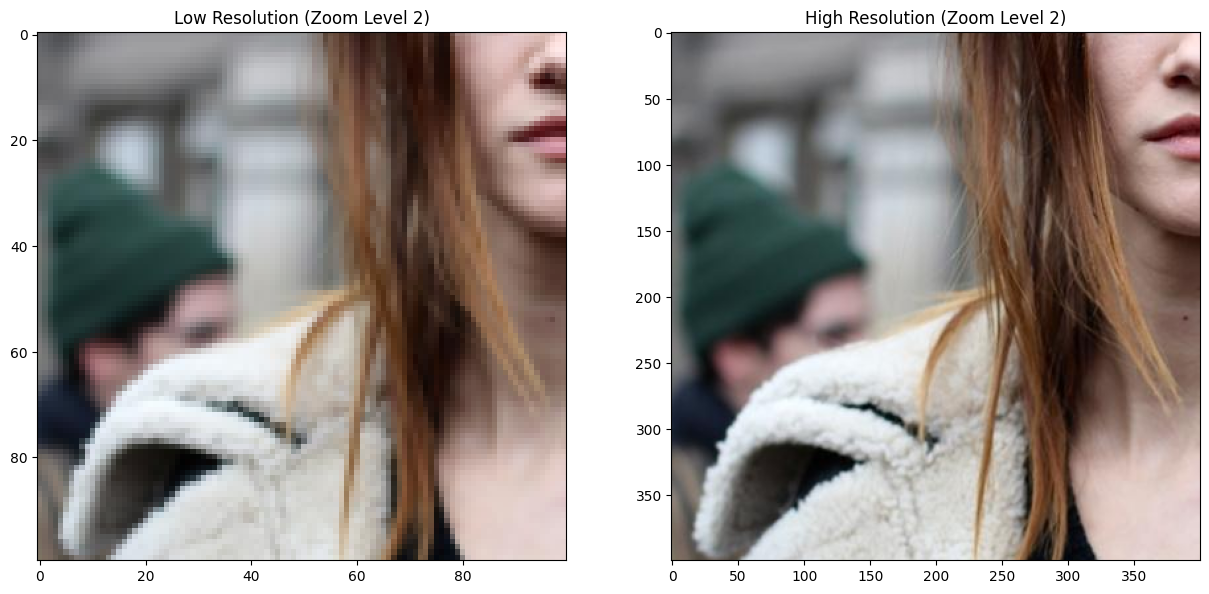

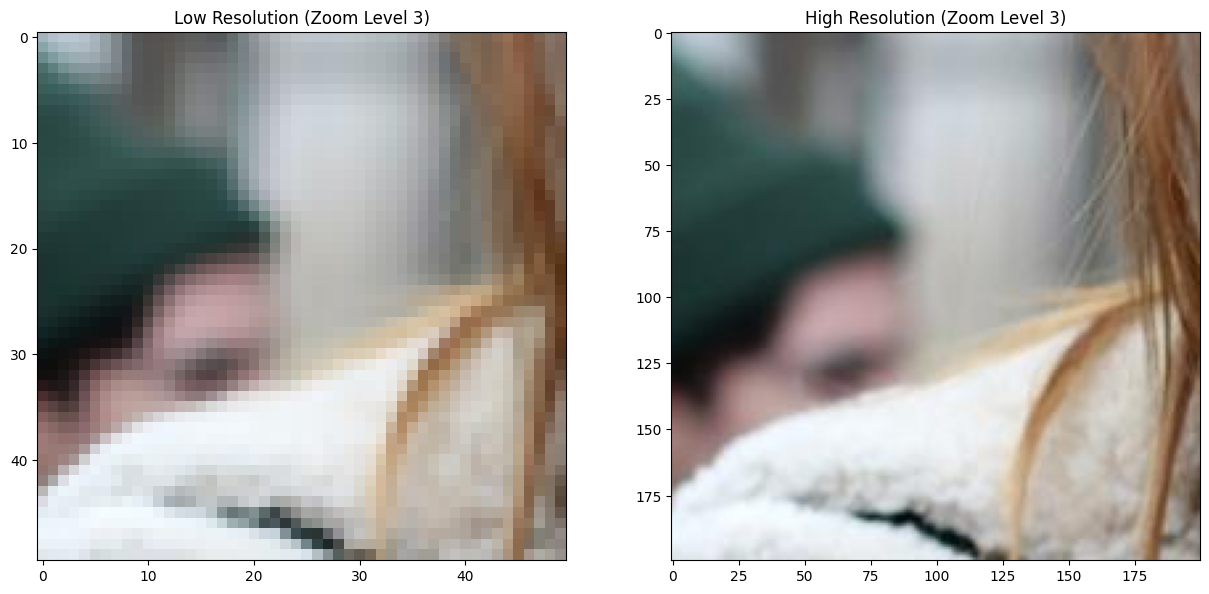

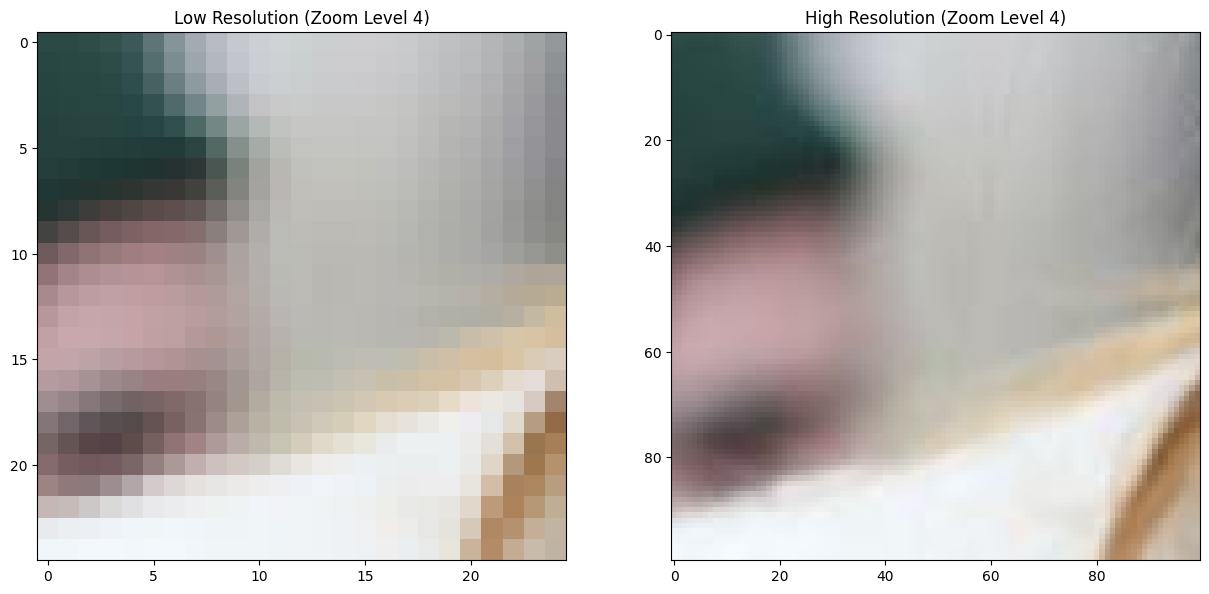

In [9]:
# Parameters
randomize_point = True
num_zooms = 4  # Hyperparameter for number of zooms

# Zoom and display images
zoom_and_display_data(low_res, high_res, SCALE_FACTOR, num_zooms, randomize_point)

## LOAD MODEL

In [32]:
# PaperSR
# model_name = 'PaperSR~10_4_32_0.0005_BEST'
# model = PaperSR(scale=SCALE_FACTOR).to(device)


# FSRCNN
# model_name = 'FSRCNN~10_4_32_0.0005_BEST'
# model = FSRCNN(scale_factor=SCALE_FACTOR).to(device)


# # ResFSRCNN
# model_name = 'ResFSRCNN_20_4_32_0.0005_BEST'
# model = ResFSRCNN(scale_factor=SCALE_FACTOR).to(device)


# GanSR
model_name = 'Generator~20_4_8_G_BEST'
model = Generator(doubling_number=2, B=6).to(device)


In [33]:
# import model from state dict
name = f'./models/{model_name}.pth'


if model_name.startswith('ResFSRCNN'): model.load_state_dict(torch.load(name)['model_state_dict'])
else: model.load_state_dict(torch.load(name))


# Set model to evaluation mode
model.eval()

Generator(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (block2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

## Visualize Model Predictions

In [12]:
# Function to update the plot
def update_plot(mse_list, psnr_list, ssim_list, ifc_list):
    plt.clf()  # Clear the current figure
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Increase the figure size

    # Plot for Mean Squared Error
    axs[0, 0].plot(mse_list, label='MSE', color='tab:red')
    axs[0, 0].set_title('Mean Squared Error over Batches')
    axs[0, 0].set_xlabel('Batch')
    axs[0, 0].set_ylabel('MSE')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot for Peak Signal-to-Noise Ratio
    axs[0, 1].plot(psnr_list, label='PSNR', color='tab:blue')
    axs[0, 1].set_title('Peak Signal-to-Noise Ratio over Batches')
    axs[0, 1].set_xlabel('Batch')
    axs[0, 1].set_ylabel('PSNR')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot for Structural Similarity Index
    axs[1, 0].plot(ssim_list, label='SSIM', color='tab:green')
    axs[1, 0].set_title('Structural Similarity Index over Batches')
    axs[1, 0].set_xlabel('Batch')
    axs[1, 0].set_ylabel('SSIM')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot for Information Fidelity Criterion
    axs[1, 1].plot(ifc_list, label='IFC', color='tab:purple')
    axs[1, 1].set_title('Information Fidelity Criterion over Batches')
    axs[1, 1].set_xlabel('Batch')
    axs[1, 1].set_ylabel('IFC')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()  # Adjust spacing between plots to prevent overlap
    plt.draw()
    plt.pause(0.001)  # Pause to update the plot

def visualize_random(input_img, output_img, label_img, rand=True):
    if rand: random_index = random.randint(0, len(input_img) - 1)
    else: random_index = 0

    low_res = input_img[random_index].cpu().detach()
    up_res = output_img[random_index].cpu().detach()
    high_res = label_img[random_index].cpu().detach()
    visualize_images(low_res, up_res, high_res)  # You will need to define this function


<Figure size 640x480 with 0 Axes>

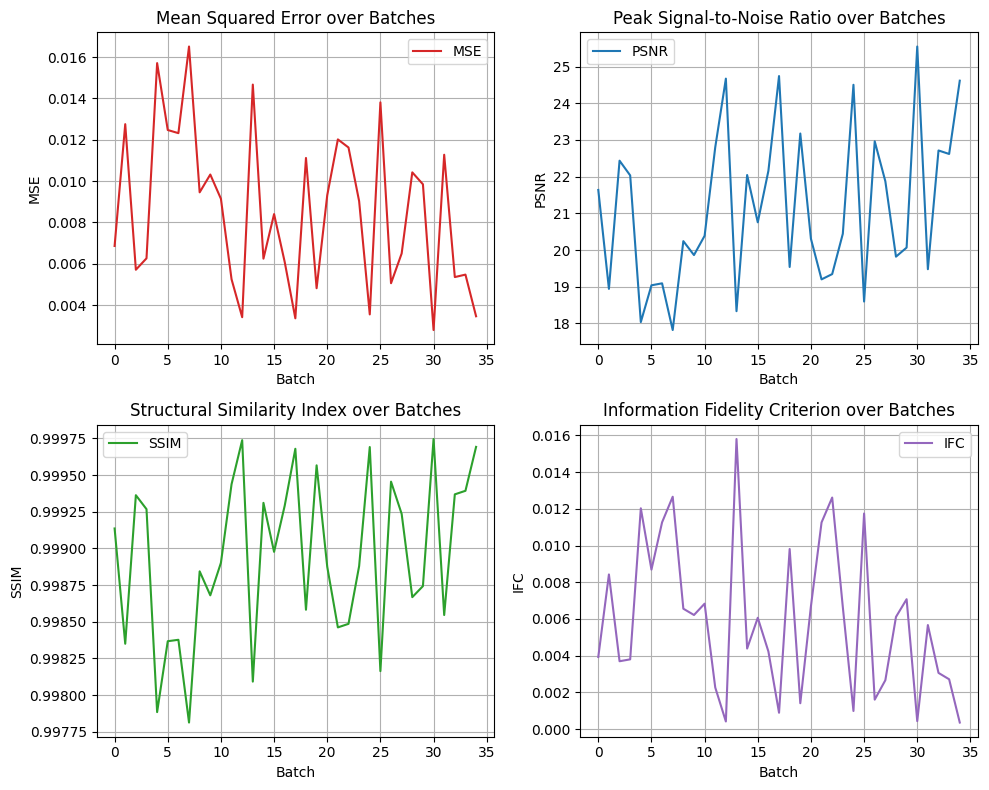

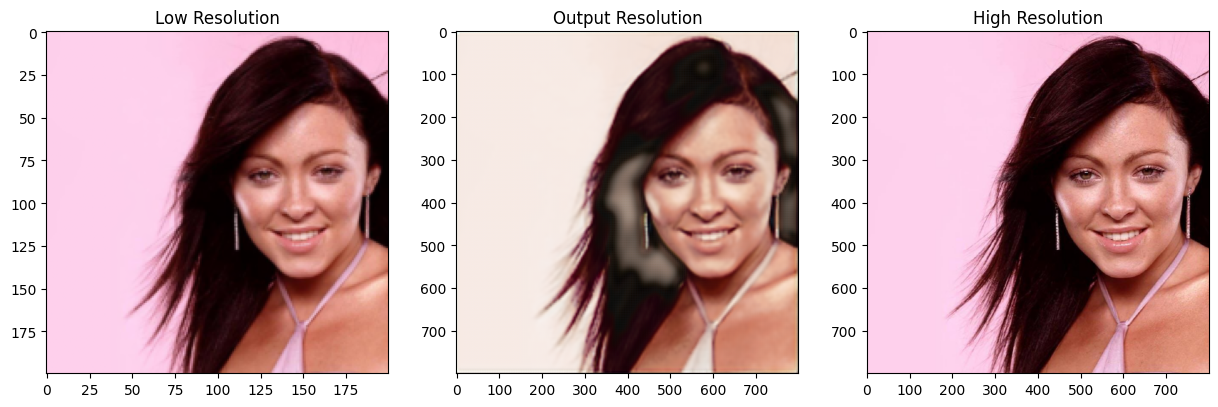

In [ ]:
# Initialize interactive mode for plotting
plt.ion()

img_outputs = []

# Lists to store metric values
mse_values = []
psnr_values = []
ssim_values = []
ifc_values = []

# Test loop
for inputs, labels in test_loader:
    # clear CUDA cache
    torch.cuda.empty_cache()

    # Move data to device
    inputs, labels = inputs.to(device), labels.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs)
        img_outputs.append(outputs)

        # Compute metrics and append to lists
        mse_value = mse_loss(outputs, labels)
        psnr_value = psnr(outputs, labels)
        ssim_value = ssim(outputs, labels)
        ifc_value = ifc(outputs, labels)

    # Append to lists
    mse_values.append(mse_value)
    psnr_values.append(psnr_value)
    ssim_values.append(ssim_value)
    ifc_values.append(ifc_value)

    # Clear previous output and update the plots dynamically
    clear_output(wait=True)

    # Update the plot dynamically
    update_plot(mse_values, psnr_values, ssim_values, ifc_values)

    # Visualization of the images
    visualize_random(inputs, outputs, labels)

# Disable interactive mode after testing
plt.ioff()


In [ ]:
# Final Scores
print(f'Mean MSE: {sum(mse_values) / len(mse_values):.4f}')
print(f'Mean PSNR: {sum(psnr_values) / len(psnr_values):.4f}')
print(f'Mean SSIM: {sum(ssim_values) / len(ssim_values):.4f}')
print(f'Mean IFC: {sum(ifc_values) / len(ifc_values):.4f}')

Mean MSE: 0.0086
Mean PSNR: 21.1388
Mean SSIM: 0.9989
Mean IFC: 0.0060


## Visualize Predictions

In [34]:
randomize_idx = False # Set to False to disable randomization
custom_idx = 10        # Set to specific index if randomize_idx is False


# Randomly select an image from the dataset
random_index = random.randint(0, len(dataset) - 1) if randomize_idx else custom_idx
print(f"Random image index: {random_index}")


low_res, high_res = dataset[random_index]
up_res = model(low_res.unsqueeze(0).to(device)).squeeze(0).cpu().detach()
print(low_res.shape, up_res.shape, high_res.shape)

Random image index: 10
torch.Size([3, 200, 200]) torch.Size([3, 800, 800]) torch.Size([3, 800, 800])


In [30]:
# Calculate scale factors
scale_factor_x = high_res.shape[-1] / low_res.shape[-1]
scale_factor_y = high_res.shape[-2] / low_res.shape[-2]

assert scale_factor_x == scale_factor_y, "Scale factors are not equal"

if scale_factor_x != SCALE_FACTOR:
    SCALE_FACTOR = int(scale_factor_x)

print(f'Scale Factor: {SCALE_FACTOR}')

Scale Factor: 4


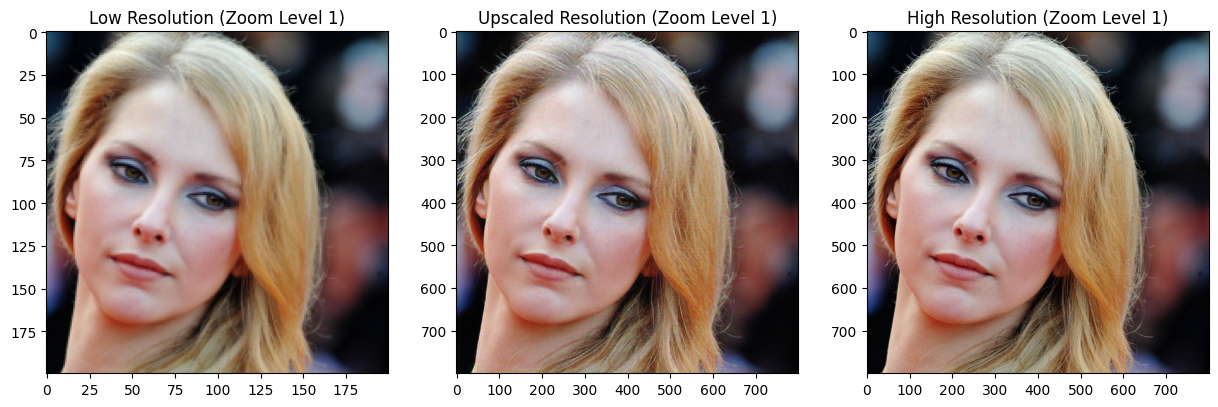

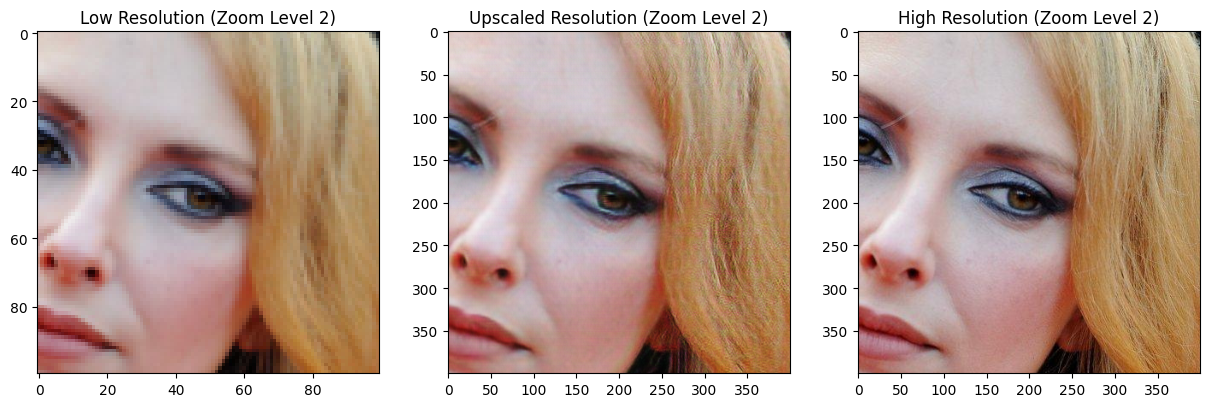

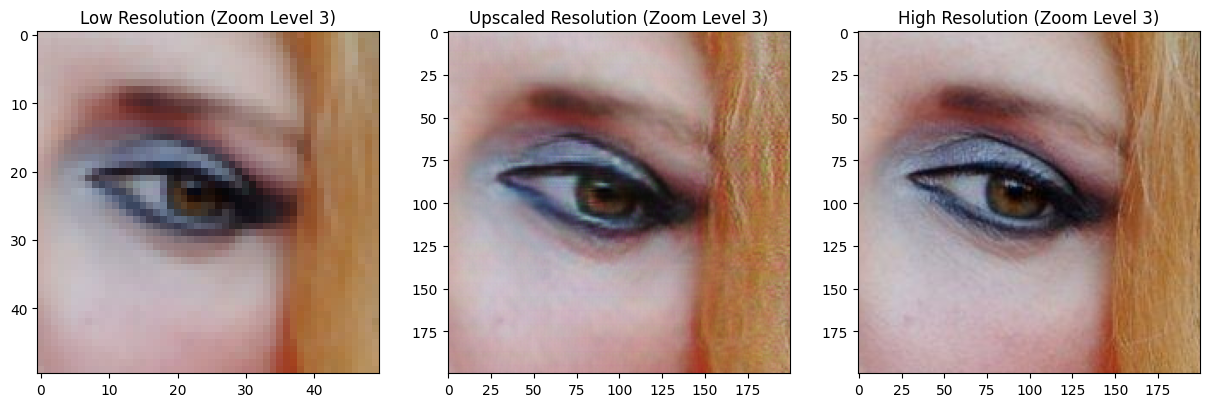

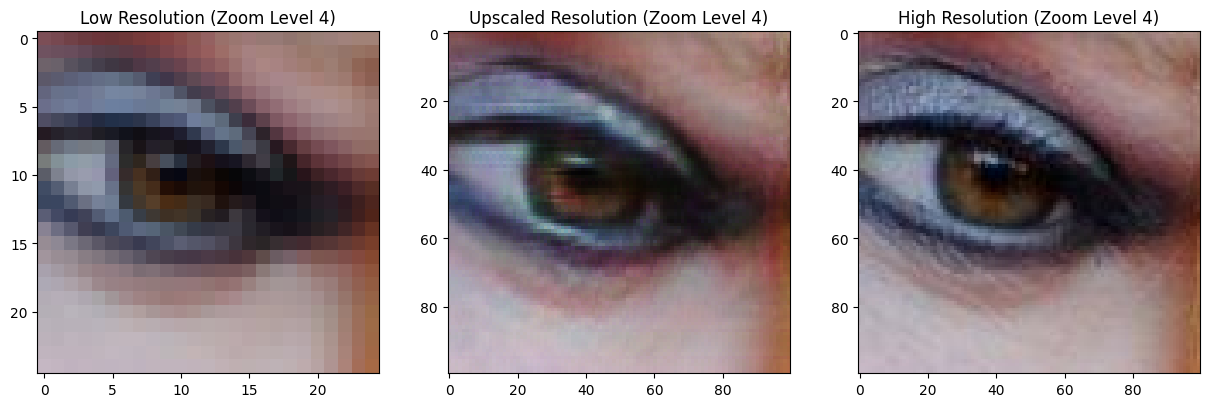

In [35]:
# Parameters
randomize_point = False  # Hyperparameter for randomizing point
num_zooms = 4  # Hyperparameter for number of zooms
# Zoom and display images
zoom_and_display_results(low_res, up_res, high_res, SCALE_FACTOR, num_zooms, randomize_point)